In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
import numpy as np
import sklearn.datasets as datasets
import hess.utils as utils

In [2]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [3]:
X, Y = twospirals(500, noise=1.5)

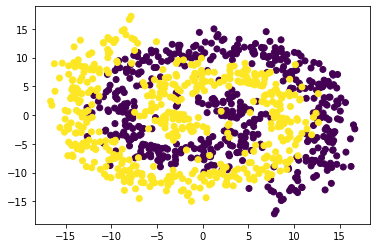

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [5]:
train_x = torch.FloatTensor(X)

In [6]:
train_y = torch.FloatTensor(Y).unsqueeze(-1)

In [7]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train_x, train_y = train_x.cuda(), train_y.cuda()

In [8]:
in_dim = 2
out_dim = 1
model = hess.nets.SimpleNet(in_dim, out_dim, n_hidden=5, hidden_size=20,
                     activation=torch.nn.ELU(), bias=True)

In [9]:
print(sum(p.numel() for p in model.parameters()))

2181


In [10]:
par_list = model.parameters()
n_par = sum(torch.numel(p) for p in par_list)

In [11]:
if use_cuda:
    model = model.cuda()

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.BCEWithLogitsLoss()

losses = []

for step in range(2000):
    optimizer.zero_grad()
    outputs = model(train_x)

    loss=loss_func(outputs, train_y)
    trainL = loss.item()
    print("train loss = ", trainL)
    losses.append(trainL)
    loss.backward()
    optimizer.step()
    
#     ## compute test loss ##
#     outputs = model(test_x)
#     testL = loss_func(outputs,test_y).item()
#     test_losses.append(testL)
#     print("test loss = ", testL)


train loss =  0.6952427625656128
train loss =  0.669172465801239
train loss =  0.6519207954406738
train loss =  0.6522139310836792
train loss =  0.6517788171768188
train loss =  0.6472538113594055
train loss =  0.6452946662902832
train loss =  0.6438983082771301
train loss =  0.6429247260093689
train loss =  0.6418941020965576
train loss =  0.6392049789428711
train loss =  0.6372407078742981
train loss =  0.6369386315345764
train loss =  0.6343974471092224
train loss =  0.6304050087928772
train loss =  0.628788948059082
train loss =  0.6248465180397034
train loss =  0.6195732951164246
train loss =  0.6137601733207703
train loss =  0.6076528429985046
train loss =  0.5975119471549988
train loss =  0.5878769755363464
train loss =  0.5883848667144775
train loss =  0.5847797393798828
train loss =  0.5681278109550476
train loss =  0.5720706582069397
train loss =  0.5758617520332336
train loss =  0.5438125729560852
train loss =  0.5645750761032104
train loss =  0.5322129130363464
train loss =

train loss =  0.18021048605442047
train loss =  0.17912742495536804
train loss =  0.17863360047340393
train loss =  0.1795336753129959
train loss =  0.17922261357307434
train loss =  0.17940835654735565
train loss =  0.17873011529445648
train loss =  0.17787253856658936
train loss =  0.1778067946434021
train loss =  0.17750918865203857
train loss =  0.1779174655675888
train loss =  0.17804628610610962
train loss =  0.17817038297653198
train loss =  0.17826895415782928
train loss =  0.1782931238412857
train loss =  0.1781187504529953
train loss =  0.17807897925376892
train loss =  0.17844226956367493
train loss =  0.17847208678722382
train loss =  0.17912207543849945
train loss =  0.18045125901699066
train loss =  0.1810683310031891
train loss =  0.1813497692346573
train loss =  0.1818694919347763
train loss =  0.18122662603855133
train loss =  0.1794194132089615
train loss =  0.1775520145893097
train loss =  0.17625349760055542
train loss =  0.1751205027103424
train loss =  0.174506843

train loss =  0.18415255844593048
train loss =  0.16175386309623718
train loss =  0.21032379567623138
train loss =  0.22135208547115326
train loss =  0.19700327515602112
train loss =  0.18483686447143555
train loss =  0.1901024878025055
train loss =  0.18666763603687286
train loss =  0.16383492946624756
train loss =  0.18898440897464752
train loss =  0.16872364282608032
train loss =  0.16312138736248016
train loss =  0.17143583297729492
train loss =  0.15994295477867126
train loss =  0.16415739059448242
train loss =  0.16235902905464172
train loss =  0.15522326529026031
train loss =  0.16047316789627075
train loss =  0.1542430967092514
train loss =  0.15341083705425262
train loss =  0.15609855949878693
train loss =  0.1522686779499054
train loss =  0.15231269598007202
train loss =  0.1533098667860031
train loss =  0.14932993054389954
train loss =  0.15042875707149506
train loss =  0.1497466266155243
train loss =  0.14840415120124817
train loss =  0.1491980105638504
train loss =  0.1481

train loss =  0.12828662991523743
train loss =  0.1408175379037857
train loss =  0.14650867879390717
train loss =  0.1364082247018814
train loss =  0.1364828199148178
train loss =  0.12957872450351715
train loss =  0.1398133486509323
train loss =  0.1377522349357605
train loss =  0.13852545619010925
train loss =  0.13103938102722168
train loss =  0.1260291039943695
train loss =  0.14265289902687073
train loss =  0.14512453973293304
train loss =  0.13010671734809875
train loss =  0.134893000125885
train loss =  0.1398228406906128
train loss =  0.1432531774044037
train loss =  0.1263965368270874
train loss =  0.1306367963552475
train loss =  0.1449786126613617
train loss =  0.1353733241558075
train loss =  0.131862074136734
train loss =  0.12609995901584625
train loss =  0.14038799703121185
train loss =  0.1310480684041977
train loss =  0.1253560334444046
train loss =  0.1279257833957672
train loss =  0.1349954903125763
train loss =  0.13132141530513763
train loss =  0.13155944645404816


train loss =  0.11666067689657211
train loss =  0.11338713020086288
train loss =  0.11362209171056747
train loss =  0.11644358187913895
train loss =  0.12106239050626755
train loss =  0.12014122307300568
train loss =  0.12122486531734467
train loss =  0.1186842992901802
train loss =  0.12003545463085175
train loss =  0.1198059618473053
train loss =  0.11743305623531342
train loss =  0.11877954751253128
train loss =  0.11830808967351913
train loss =  0.12085987627506256
train loss =  0.12282294780015945
train loss =  0.12247270345687866
train loss =  0.12622995674610138
train loss =  0.13338343799114227
train loss =  0.1583479940891266
train loss =  0.18138189613819122
train loss =  0.17194555699825287
train loss =  0.14412574470043182
train loss =  0.13142570853233337
train loss =  0.1615447849035263
train loss =  0.17567451298236847
train loss =  0.2167356163263321
train loss =  0.17212626338005066
train loss =  0.2511470913887024
train loss =  0.1996389478445053
train loss =  0.20116

train loss =  0.09435378760099411
train loss =  0.09394456446170807
train loss =  0.09367521852254868
train loss =  0.09327319264411926
train loss =  0.09303705394268036
train loss =  0.09247461706399918
train loss =  0.0921495258808136
train loss =  0.09182409942150116
train loss =  0.09151700884103775
train loss =  0.09118009358644485
train loss =  0.09077337384223938
train loss =  0.09045632183551788
train loss =  0.0902494341135025
train loss =  0.08993931114673615
train loss =  0.08950788527727127
train loss =  0.0893310010433197
train loss =  0.08909684419631958
train loss =  0.08879692107439041
train loss =  0.08848590403795242
train loss =  0.08827038109302521
train loss =  0.08795099705457687
train loss =  0.08768968284130096
train loss =  0.08744774758815765
train loss =  0.0871700793504715
train loss =  0.08691120892763138
train loss =  0.08664069324731827
train loss =  0.08637074381113052
train loss =  0.0861504003405571
train loss =  0.08586964011192322
train loss =  0.085

train loss =  0.09044153988361359
train loss =  0.08955740183591843
train loss =  0.08907763659954071
train loss =  0.08819399029016495
train loss =  0.08804919570684433
train loss =  0.0871191993355751
train loss =  0.08680924773216248
train loss =  0.08649727702140808
train loss =  0.0861910730600357
train loss =  0.08565818518400192
train loss =  0.08535526692867279
train loss =  0.08465585112571716
train loss =  0.08445949852466583
train loss =  0.08388333022594452
train loss =  0.0836704894900322
train loss =  0.08317440748214722
train loss =  0.08291636407375336
train loss =  0.08248879760503769
train loss =  0.08229222148656845
train loss =  0.08185272663831711
train loss =  0.0815417543053627
train loss =  0.08118440210819244
train loss =  0.08088298887014389
train loss =  0.0805821493268013
train loss =  0.080297090113163
train loss =  0.07997478544712067
train loss =  0.07968763262033463
train loss =  0.07945441454648972
train loss =  0.0791572630405426
train loss =  0.078924

train loss =  0.06385457515716553
train loss =  0.06347932666540146
train loss =  0.0633784681558609
train loss =  0.06298218667507172
train loss =  0.06288402527570724
train loss =  0.06232636049389839
train loss =  0.061922792345285416
train loss =  0.06168350949883461
train loss =  0.061128340661525726
train loss =  0.0608832910656929
train loss =  0.06050710380077362
train loss =  0.06025281175971031
train loss =  0.05987780913710594
train loss =  0.05957488715648651
train loss =  0.059595987200737
train loss =  0.060988470911979675
train loss =  0.06731168180704117
train loss =  0.06096095219254494
train loss =  0.07964610308408737
train loss =  0.09183889627456665
train loss =  0.08331989496946335
train loss =  0.08343911170959473
train loss =  0.08460189402103424
train loss =  0.08367590606212616
train loss =  0.07684960216283798
train loss =  0.07526502758264542
train loss =  0.07934890687465668
train loss =  0.07579906284809113
train loss =  0.07255653291940689
train loss =  0

## Let's get this bread

In [13]:
import hess.utils as utils

In [14]:
par_list = model.parameters()
n_par = sum(torch.numel(p) for p in par_list)

In [15]:
hessian = torch.zeros(n_par, n_par)
for pp in range(n_par):
    base_vec = torch.zeros(n_par).unsqueeze(0)
    base_vec[0, pp] = 1.
    
    base_vec = utils.unflatten_like(base_vec, model.parameters())
    utils.eval_hess_vec_prod(base_vec, model,
                            criterion=torch.nn.BCEWithLogitsLoss(),
                            inputs=train_x, targets=train_y)
    if pp == 0:
        output = utils.gradtensor_to_tensor(model, include_bn=True)
        hessian = torch.zeros(output.nelement(), output.nelement())
        hessian[:, pp] = output
    
#     print(pp)
    hessian[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()

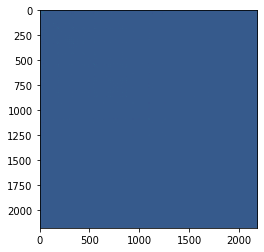

In [16]:
plt.imshow(hessian)

In [17]:
e_val, e_vec = np.linalg.eig(hessian.cpu())
idx = np.abs(e_val).argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

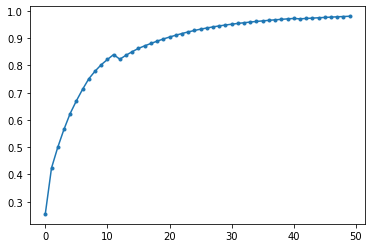

In [18]:
ne = e_val.div(torch.sum(e_val))
plt.plot(np.cumsum(ne[:50].cpu()), marker=".")

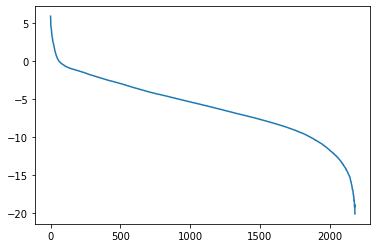

In [19]:
plt.plot(np.log(np.abs(e_val)))

## Save model to use on laptop

In [20]:
# torch.save(optimus.net.state_dict(), "../hess/saved-models/spirals.pt")
saved_pars = model.state_dict()

In [21]:
# torch.save(hessian, "../hess/saved-models/spirals_hessian.pt")

## Do Some Perturbing

In [22]:
from hess.plotting import plot_decision_boundary

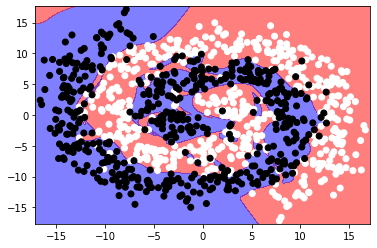

In [23]:
plot_decision_boundary(train_x, train_y, model, use_cuda=False,
                      buffer=0.5, h=0.1)

## Average Over Large Curvature Perturbations

In [24]:
buffer = 0.3
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [25]:
n_vec = 3
scale = 0.0
basis = e_vec[:, :n_vec]
n_trial = 1
pred = torch.zeros(in_grid.size(0), n_trial).cpu()
for tt in range(n_trial):
    model.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)

    perturb = utils.unflatten_like(perturb, model.parameters())
    for i, par in enumerate(model.parameters()):
        par.data = par.data + perturb[i]
        
    pred[:, tt] = torch.sigmoid(model(in_grid).squeeze().cpu())

In [26]:
avg_pred = pred.mean(1).detach().numpy().reshape(xx.shape)

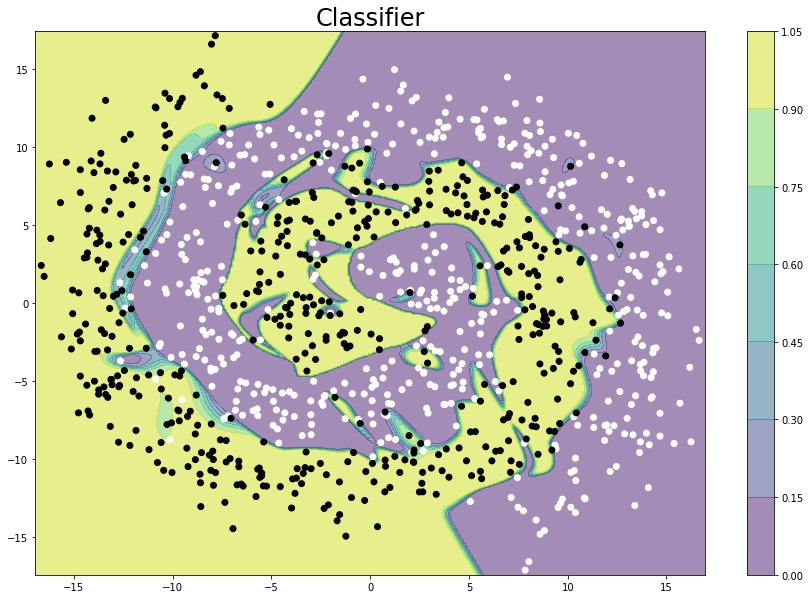

In [27]:
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, avg_pred, alpha=0.5)
# plt.title("Temp Scaled", fontsize=24)
plt.title("Classifier", fontsize=24)
plt.colorbar()
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary)
# plt.savefig("./two-spiral-classifier.pdf", bbox_inches="tight")

## Small Curvature

In [28]:
n_vec = 10
scale = 1.
basis = e_vec[:, -n_vec:]
n_trial = 1
pred = torch.zeros(in_grid.size(0), n_trial).cpu()
for tt in range(n_trial):
    model.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)

    perturb = utils.unflatten_like(perturb, model.parameters())
    for i, par in enumerate(model.parameters()):
        par.data = par.data + perturb[i]
        
    pred[:, tt] = torch.sigmoid(model(in_grid).squeeze().cpu())

In [29]:
avg_pred = pred.mean(1).detach().numpy().reshape(xx.shape)

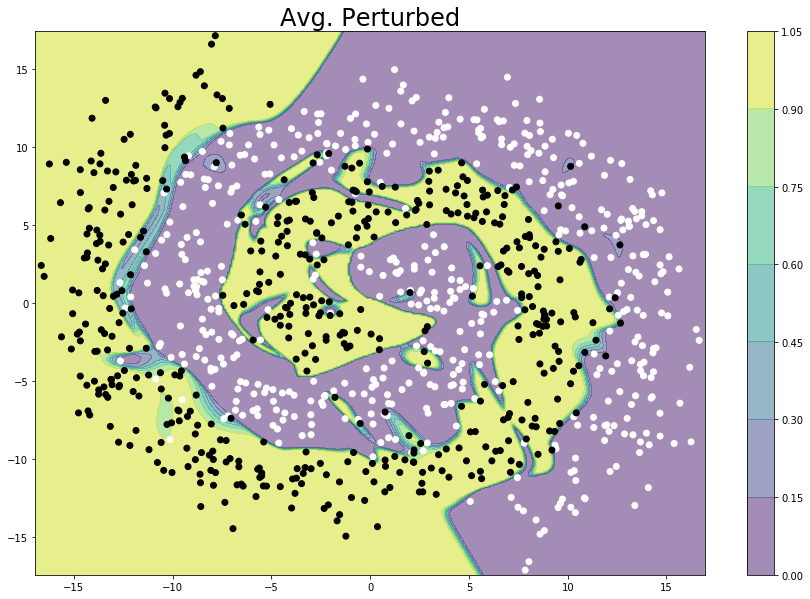

In [30]:
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, avg_pred, alpha=0.5)
plt.title("Avg. Perturbed", fontsize=24)
plt.colorbar()
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary)

## Get Loss Surfaces

In [31]:
basis = e_vec
full_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=1., n_pts=50, scale=1.,
                                             use_cuda=False)

In [32]:
nvec = 3
basis = e_vec[:, :nvec]
high_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=1., n_pts=50, scale=1.,
                                             use_cuda=False)

In [33]:
nvec = 3
basis = e_vec[:, -n_vec:]
low_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=1., n_pts=50, scale=1.,
                                             use_cuda=False)

In [34]:
ymin = torch.min(torch.cat((full_loss_surface, high_loss_surface, low_loss_surface)))
ymax = torch.max(torch.cat((full_loss_surface, high_loss_surface, low_loss_surface)))

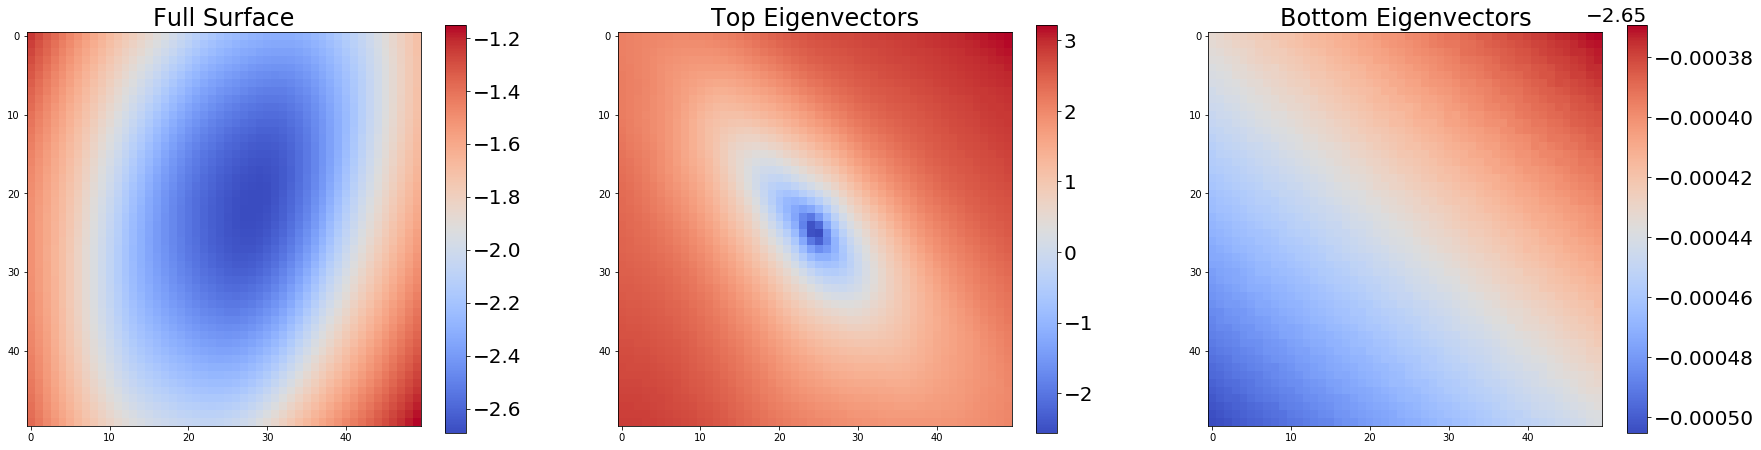

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(30, 7.5))
im = ax[0].imshow(full_loss_surface.log().detach(), cmap='coolwarm')
# ax[0].autoscale(False)
cbar=fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.offsetText.set(size=20)
ax[0].set_title("Full Surface",
               fontsize=24)

im = ax[1].imshow(high_loss_surface.log().detach(), cmap='coolwarm')
cbar=fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
# ax[1].autoscale(False)
ax[1].set_title("Top Eigenvectors",
               fontsize=24)

im = ax[2].imshow(low_loss_surface.log().detach(), cmap='coolwarm')
cbar=fig.colorbar(im, ax=ax[2])
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.offsetText.set(size=20)
ax[2].set_title("Bottom Eigenvectors",
               fontsize=24);
plt.savefig("./spiral-loss-surface.pdf", bbox_inches="tight")
plt.show()

In [36]:
n_vec = 1000
basis = e_vec[:, -n_vec:]
low_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=1., n_pts=50, scale=1.,
                                             use_cuda=False)

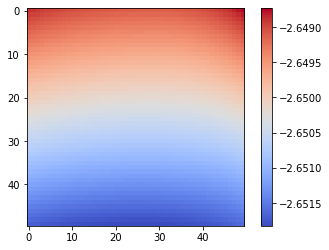

In [37]:
plt.imshow(low_loss_surface.log().detach(), cmap="coolwarm")
plt.colorbar()

In [38]:
nvec = 1500
basis = e_vec
ls1 = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=10., n_pts=50, scale=2.,
                                             use_cuda=False)

In [39]:
basis = e_vec[:, -n_vec:]
ls2 = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=10., n_pts=50, scale=2.,
                                             use_cuda=False)
ls3 = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=torch.nn.BCEWithLogitsLoss(),
                                             rng=10., n_pts=50, scale=2.,
                                             use_cuda=False)

In [40]:
ymin = torch.min(torch.cat((ls1, ls2, ls3))).log()
ymax = torch.max(torch.cat((ls1, ls2, ls3))).log()

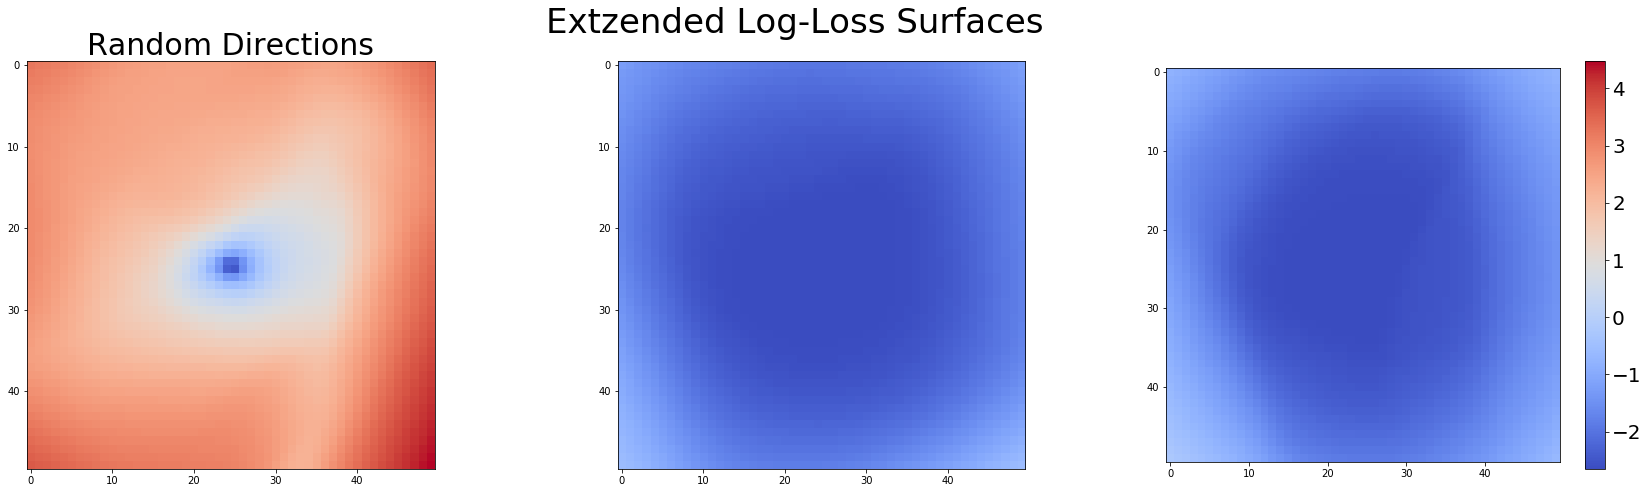

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(30, 7.5))
im = ax[0].imshow(ls1.log().detach(), cmap='coolwarm', vmin=ymin, vmax=ymax)
# cbar=fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.offsetText.set(size=20)
ax[0].set_title("Random Directions",
               fontsize=30)

im = ax[1].imshow(ls2.log().detach(), cmap='coolwarm', vmin=ymin, vmax=ymax)
# cbar=fig.colorbar(im, ax=ax[1])
# cbar.ax.tick_params(labelsize=20)
# cbar.ax.yaxis.offsetText.set(size=20)
# ax[1].set_title("Top Eigenvectors",
#                fontsize=24)

im = ax[2].imshow(ls3.log().detach(), cmap='coolwarm', vmin=ymin, vmax=ymax)
cbar=fig.colorbar(im, ax=ax[2])
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.offsetText.set(size=20)
# ax[2].set_title("Bottom Eigenvectors",
#                fontsize=24);
fig.suptitle("Extzended Log-Loss Surfaces", fontsize=34)
plt.savefig("./ext-loss-surface.pdf", bbox_inches="tight")
plt.show()

In [42]:
pars = utils.flatten([p for p in model.parameters()]) 

(array([0.00565743, 0.00660034, 0.02734425, 0.08957599, 0.35641816,
        1.03530988, 0.47616711, 0.04808817, 0.00848615, 0.00282872]),
 array([-2.702355  , -2.2160861 , -1.7298175 , -1.2435489 , -0.7572802 ,
        -0.27101147,  0.21525721,  0.7015259 ,  1.1877946 ,  1.6740633 ,
         2.160332  ], dtype=float32),
 <a list of 10 Patch objects>)

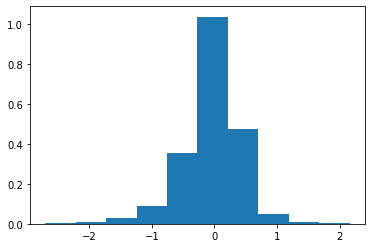

In [43]:
plt.hist(pars.detach(), density=True)

In [44]:
pars.mean()

tensor(-0.0411, grad_fn=<MeanBackward0>)

In [45]:
pars.var()

tensor(0.2092, grad_fn=<VarBackward0>)

### Generate Parameter Perturbations in Low-Curvature Directions

In [46]:
buffer = 0.4
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [47]:
model.load_state_dict(saved_pars)
orig_preds = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)


In [48]:
n_vec = 1500
scale = 1.
basis = e_vec[:, -n_vec:]

model.load_state_dict(saved_pars)
wghts = torch.randn(n_vec).cpu()
perturb = basis.matmul(wghts.unsqueeze(-1)).t()
perturb = perturb.div(perturb.norm()).mul(scale)

perturb = utils.unflatten_like(perturb, model.parameters())
for i, par in enumerate(model.parameters()):
    par.data = par.data + perturb[i]

low_pred = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)

In [98]:
n_vec = 3
scale = 1.
basis = e_vec[:, :n_vec]


model.load_state_dict(saved_pars)
wghts = torch.randn(n_vec).cpu()
perturb = basis.matmul(wghts.unsqueeze(-1)).t()
perturb = perturb.div(perturb.norm()).mul(scale)

perturb = utils.unflatten_like(perturb, model.parameters())
for i, par in enumerate(model.parameters()):
    par.data = par.data + perturb[i]

high_pred = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)

In [99]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [100]:
import seaborn as sns
import pandas as pd

dat = pd.DataFrame({'x1': train_x[:, 0], 'x2': train_x[:, 1], "y":train_y[:, 0]})

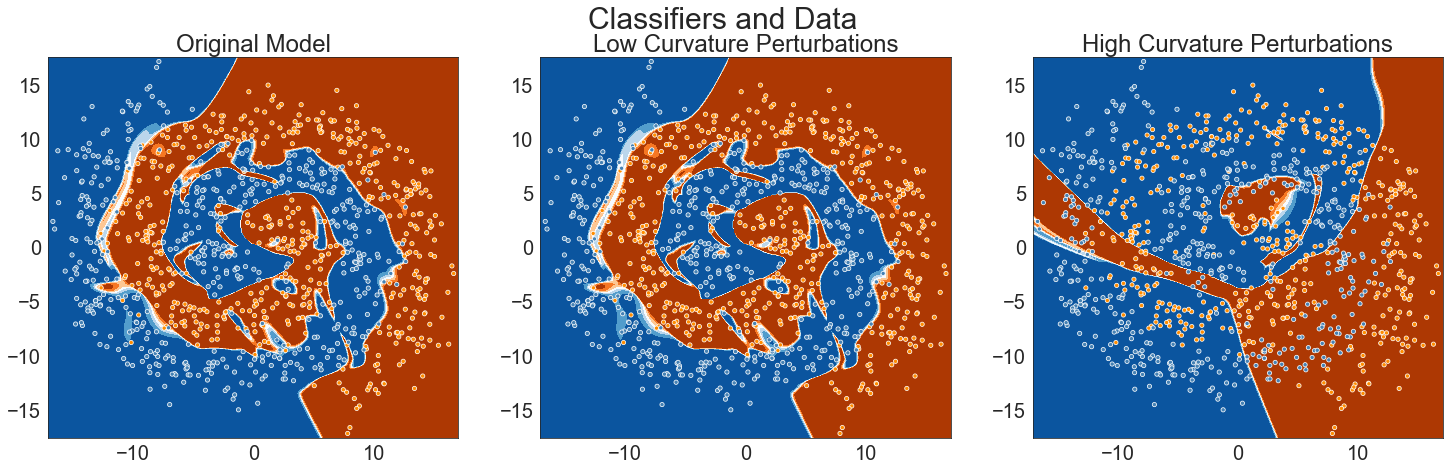

In [101]:
sup_fs = 30
title_fs = 24
ax_fs = 20
colors = newcmp


sns.set_style("white")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

fig.suptitle('Classifiers and Data', fontsize=sup_fs)


ax1.contourf(xx, yy, orig_preds.detach(), cmap=colors)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax1,
               palette=['darkorange', 'steelblue'], size=1, legend=False)
ax1.set_title("Original Model", fontsize=title_fs)
ax1.tick_params(axis="both", labelsize=ax_fs)
ax1.set(xlabel='', ylabel='')

ax2.contourf(xx, yy, low_pred.detach(), cmap=colors)
# ax2.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
#            s=3)
ax2.set_title("Low Curvature Perturbations", fontsize=title_fs)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax2,
               palette=['darkorange', 'steelblue'], size=1, legend=False)
ax2.tick_params(axis="both", labelsize=ax_fs)
ax2.set(xlabel='', ylabel='')

ax3.contourf(xx, yy, high_pred.detach(), cmap=colors)
# ax3.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
#         s=3)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax3,
               palette=['darkorange', 'steelblue'], size=1, legend=False)
ax3.set_title("High Curvature Perturbations", fontsize=title_fs)
ax3.tick_params(axis="both", labelsize=ax_fs)
ax3.set(xlabel='', ylabel='')

plt.savefig("./perturbed-classifiers.pdf", bbox_inches='tight')

## Quantify Sensitivity to Perturbations

In [157]:
n_bases = 20
n_scale = 20
max_scale = 1.
scales = torch.linspace(0, max_scale, n_scale)
loss_outs = torch.zeros(n_bases, n_scale)
loss_func = torch.nn.BCEWithLogitsLoss()
n_restarts = 10

for base in range(n_bases):
    for scale_ind, scale in enumerate(scales):
        basis = e_vec[:, :(base+1)]
        temp_losses = torch.zeros(n_restarts)
        for rst in range(n_restarts):

            model.load_state_dict(saved_pars)
            wghts = torch.randn(base+1).cpu()
            perturb = basis.matmul(wghts.unsqueeze(-1)).t()
            perturb = perturb.div(perturb.norm()).mul(scale)

            perturb = utils.unflatten_like(perturb, model.parameters())
            for i, par in enumerate(model.parameters()):
                par.data = par.data + perturb[i]

            outputs = model(train_x)
            temp_losses[rst] = loss_func(outputs, train_y).item()
            
        loss_outs[base,  scale_ind] = temp_losses.mean()

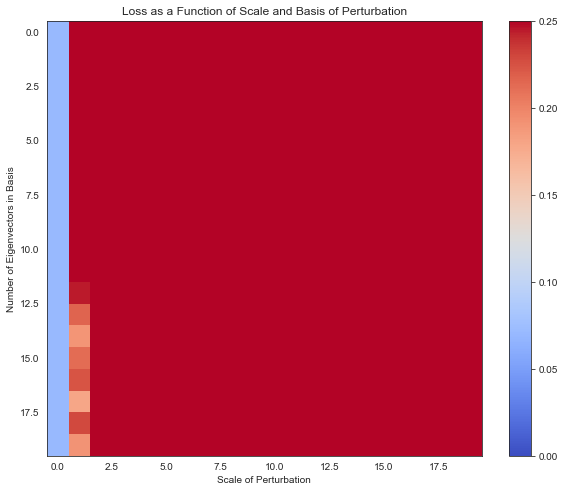

In [158]:
plt.figure(figsize=(10, 8))
plt.imshow(loss_outs.detach(), cmap="coolwarm", vmin=0., vmax=0.25)
plt.colorbar()
plt.ylabel("Number of Eigenvectors in Basis")
plt.xlabel("Scale of Perturbation")
# plt.yticks(np.arange(0, n_bases, 5), np.arange(0, n_bases, 5), va='center')
# plt.yticks(np.arange(n_bases), 1+np.arange(n_bases))
loc, lab = plt.yticks()
plt.title("Loss as a Function of Scale and Basis of Perturbation")
plt.show()

In [159]:
loss_table = torch.cat((scales.unsqueeze(0), loss_outs), 0)
loss_table = torch.cat((torch.arange(n_bases+1).unsqueeze(-1).float(), loss_table), 1)

In [160]:
loss_table.shape

torch.Size([21, 21])

In [161]:
loss_table

tensor([[ 0.0000,  0.0000,  0.0526,  0.1053,  0.1579,  0.2105,  0.2632,  0.3158,
          0.3684,  0.4211,  0.4737,  0.5263,  0.5789,  0.6316,  0.6842,  0.7368,
          0.7895,  0.8421,  0.8947,  0.9474,  1.0000],
        [ 1.0000,  0.0706,  0.5493,  1.4762,  2.7338,  4.1784,  5.5555,  6.7962,
          7.7748,  8.8504,  8.5064,  9.0377,  9.7907,  9.7525, 11.1516, 10.0158,
         11.6062, 10.6049, 11.5028, 11.9726, 11.8582],
        [ 2.0000,  0.0706,  0.4301,  1.3625,  2.3144,  3.5682,  4.8574,  6.2341,
          7.3321,  8.4655,  9.2445, 10.4856, 10.5406, 11.8522, 10.3235,  9.9030,
         11.7693, 11.0772, 12.0429, 11.4886, 13.1717],
        [ 3.0000,  0.0706,  0.4087,  1.1552,  2.3332,  3.3729,  4.7326,  6.3287,
          7.5296,  9.0244,  9.0544,  9.5281, 10.7371, 10.7768, 13.4277, 11.9754,
         13.3886, 13.6687, 15.2044, 19.2584, 14.8091],
        [ 4.0000,  0.0706,  0.3450,  0.9746,  1.8415,  2.9124,  4.3054,  5.8176,
          7.5254,  8.1541,  7.7757, 11.1805, 11.363

In [162]:
np.savetxt("high_curve_losses.txt", loss_table, delimiter=' & ', fmt='%.4f', newline=' \\\\\n')

In [163]:
n_bases = 2000
n_scale = 20
max_scale = 1.
scales = torch.linspace(0, max_scale, n_scale)
low_curve_loss_outs = torch.zeros(n_scale)
loss_func = torch.nn.BCEWithLogitsLoss()
n_restarts = 10

# for base in range(n_bases):
for scale_ind, scale in enumerate(scales):
    basis = e_vec[:, -n_bases:]
    temp_losses = torch.zeros(n_restarts)
    for rst in range(n_restarts):

        model.load_state_dict(saved_pars)
        wghts = torch.randn(n_bases).cpu()
        perturb = basis.matmul(wghts.unsqueeze(-1)).t()
        perturb = perturb.div(perturb.norm()).mul(scale)

        perturb = utils.unflatten_like(perturb, model.parameters())
        for i, par in enumerate(model.parameters()):
            par.data = par.data + perturb[i]

        outputs = model(train_x)
        temp_losses[rst] = loss_func(outputs, train_y).item()

    low_curve_loss_outs[scale_ind] = temp_losses.mean()

In [164]:
low_curve_loss_outs

tensor([0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0706, 0.0708, 0.0706, 0.0709,
        0.0709, 0.0711, 0.0712, 0.0724, 0.0717, 0.0721, 0.0730, 0.0736, 0.0742,
        0.0747, 0.0730])

In [165]:
low_curve_loss_table = torch.cat((scales.unsqueeze(0), low_curve_loss_outs.unsqueeze(0)), 0)

In [167]:
np.savetxt("low_curve_losses.txt", low_curve_loss_table, delimiter=' & ', fmt='%.2f', newline=' \\\\\n')